In [1]:
from model import UNet
import pickle
import torch.utils.data as data
import random
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import os
import shutil
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [2]:
data_path = '/mnt/storage-ssd/zhouxinghui/AI_CLEAN_DATASET/dirty_scale_maxbaseline.pkl'
dataset = pickle.load(open(data_path, "rb"))

In [3]:
dataset[0]['x'].dtype

dtype('float32')

In [4]:
p = int(len(dataset)*0.5)
random.shuffle(dataset)

train_set = dataset[:p]
test_set = dataset[p:]

train_loader = data.DataLoader(
    dataset = train_set,
    batch_size = 850,
    shuffle = True,
    num_workers=16
)

test_loader = data.DataLoader(
    dataset = test_set,
    batch_size = 850,
    shuffle = True,
    num_workers=16
)

In [5]:
def minmax(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img


def plot_compare(img_dir, img_recon, img_true, exp_name, title):
    img_dir = minmax(img_dir)
    img_recon = minmax(img_recon)
    img_true = minmax(img_true)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
    ax = axes.ravel()

    ssim_true = ssim(img_true, img_true, data_range=1.0)
    ssim_dir = ssim(img_true, img_dir, data_range=1.0)
    ssim_recon = ssim(img_true, img_recon, data_range=1.0)
    
    mse_true = mse(img_true, img_true)
    mse_dir = mse(img_true, img_dir)
    mse_recon = mse(img_true, img_recon)

    # 添加颜色条
    im0 = ax[0].imshow(img_true, cmap='jet')
    ax[0].set_xlabel(f'SSIM: {ssim_true:.2f}\n MSE:{mse_true:.5f}')
    ax[0].set_title('GT')
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(img_dir, cmap='jet')
    ax[1].set_xlabel(f'SSIM: {ssim_dir:.2f} \n MSE:{mse_dir:.5f}')
    ax[1].set_title('DIRTY IMAGE')
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(img_recon, cmap='jet')
    ax[2].set_xlabel(f'SSIM: {ssim_recon:.2f} \n MSE:{mse_recon:.5f}')
    ax[2].set_title('RECON IMAGE')
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    # plt.show()
    plt.savefig(f'results/{exp_name}/{title}')
    plt.close()
    return ssim_recon

def plot_compare(img_dir, img_recon, img_true, exp_name, title):
    img_dir = minmax(img_dir)
    img_recon = minmax(img_recon)
    img_true = minmax(img_true)
    
    # 计算残图
    img_diff = img_recon - img_true
    # img_diff = minmax(img_diff)  # 归一化残图

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    ssim_true = ssim(img_true, img_true, data_range=1.0)
    ssim_dir = ssim(img_true, img_dir, data_range=1.0)
    ssim_recon = ssim(img_true, img_recon, data_range=1.0)
    ssim_diff = ssim(img_true, img_diff, data_range=1.0)  # 计算残图的 SSIM

    mse_true = mse(img_true, img_true)
    mse_dir = mse(img_true, img_dir)
    mse_recon = mse(img_true, img_recon)
    mse_diff = mse(img_true, img_diff)  # 计算残图的 MSE

    # 添加颜色条
    im0 = ax[0].imshow(img_true, cmap='jet')
    ax[0].set_xlabel(f'SSIM: {ssim_true:.2f}\n MSE:{mse_true:.5f}')
    ax[0].set_title('GT')
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(img_dir, cmap='jet')
    ax[1].set_xlabel(f'SSIM: {ssim_dir:.2f} \n MSE:{mse_dir:.5f}')
    ax[1].set_title('DIRTY IMAGE')
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(img_recon, cmap='jet')
    ax[2].set_xlabel(f'SSIM: {ssim_recon:.2f} \n MSE:{mse_recon:.5f}')
    ax[2].set_title('RECON IMAGE')
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    im3 = ax[3].imshow(img_diff, cmap='jet')
    ax[3].set_xlabel(f'SSIM: {ssim_diff:.2f} \n MSE:{mse_diff:.5f}')
    ax[3].set_title('RECON - TARGET')
    fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.savefig(f'results/{exp_name}/{title}')
    plt.close()
    return ssim_recon

def min_max_normalize(x):
    """
    对输入张量 x 的每张图像进行 Min-Max 归一化。
    假设 x 的形状为 [batch_size, channels, height, width]。
    """
    # 计算每张图像的最小值和最大值
    min_vals = x.view(x.size(0), -1).min(dim=1).values.view(-1, 1, 1, 1)
    max_vals = x.view(x.size(0), -1).max(dim=1).values.view(-1, 1, 1, 1)

    # 批量 Min-Max 归一化
    normalized_x = (x - min_vals) / (max_vals - min_vals + 1e-8)  # 添加小值防止分母为零

    return normalized_x

In [6]:
dataset[0]['x'].dtype

dtype('float32')

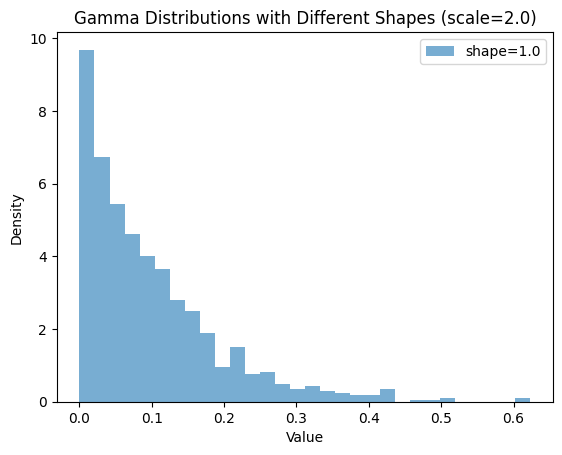

In [7]:
# 设置尺度参数
scale = 0.1  # θ

# 不同的形状参数
shapes = [1.0]

# 生成并绘制不同形状参数下的伽马分布
for shape in shapes:
    random_numbers = np.random.gamma(shape, scale, size=1000)
    plt.hist(random_numbers, bins=30, density=True, alpha=0.6, label=f"shape={shape}")

plt.title("Gamma Distributions with Different Shapes (scale=2.0)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [8]:
import torch.fft as fft

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        # 图像域的MSE损失
        mse_loss = self.mse_loss(output, target)

        # 频率域的MSE损失
        output_fft = fft.fft2(output)
        target_fft = fft.fft2(target)
        spectral_loss = self.mse_loss(output_fft, target_fft)

        # 结合图像域和频率域的损失
        combined_loss = self.alpha * mse_loss + (1 - self.alpha) * spectral_loss

        return combined_loss
    


In [9]:
class SSIMLoss(nn.Module):
    def __init__(self, data_range=1.0, device=None):
        """
        初始化SSIM损失函数
        :param data_range: 数据范围，默认为1.0，表示输入数据的范围是[0, 1]
        :param device: 指定设备（例如 'cuda' 或 'cpu'）
        """
        super(SSIMLoss, self).__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range).to(device)

    def forward(self, pred, target):
        """
        前向传播，计算SSIM损失
        :param pred: 预测图像，形状为 [batch_size, 1, H, W]
        :param target: 目标图像，形状为 [batch_size, 1, H, W]
        :return: SSIM损失值
        """
        # 归一化预测图像和目标图像到 [0, 1] 范围
        pred_normalized = self.normalize(pred)
        target_normalized = self.normalize(target)

        # 计算SSIM值
        ssim_value = self.ssim(pred_normalized, target_normalized)
        loss = 1 - ssim_value  # 将SSIM值转换为损失值
        return loss

    @staticmethod
    def normalize(image):
        """
        将图像归一化到 [0, 1] 范围
        :param image: 输入图像，形状为 [batch_size, 1, H, W]
        :return: 归一化后的图像
        """
        min_value = image.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_value = image.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        normalized_image = (image - min_value) / (max_value - min_value + 1e-9)
        return normalized_image
        


    
class TotalLoss(nn.Module):
    def __init__(self, alpha=0.1, beta=0.1,  data_range=1.0, device=None):
        """
        初始化复合损失函数
        :param alpha: SSIM损失的权重，MSE损失的权重为 (1 - alpha)
        :param data_range: 数据范围，默认为1.0，表示输入数据的范围是[0, 1]
        :param device: 指定设备（例如 'cuda' 或 'cpu'）
        """
        super(TotalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ssim_loss = SSIMLoss(data_range=data_range, device=device)
        self.mse_loss = nn.MSELoss()
        self.L1_loss = nn.L1Loss()

    def forward(self, pred, target):
        """
        前向传播，计算复合损失
        :param pred: 预测图像，形状为 [batch_size, 1, H, W]
        :param target: 目标图像，形状为 [batch_size, 1, H, W]
        :return: 复合损失值
        """
        ssim_loss_value = self.ssim_loss(pred, target)
        mse_loss_value = self.mse_loss(pred, target) 
        l1_loss_value = self.L1_loss(pred, target)
        # spectral_loss_value = self.spectral_loss(pred, target)
        # grad_loss_value = gradient_loss(pred) * 0.1
        # 组合损失
        total_loss = mse_loss_value +  self.beta * l1_loss_value + self.alpha * ssim_loss_value
        # print(f"SSIM Loss: {ssim_loss_value.item()}, MSE Loss: {mse_loss_value.item()}")
        # print(f"SSIM Loss: {ssim_loss_value.item()}, MSE Loss: {mse_loss_value.item()}, Spectral Loss: {spectral_loss_value.item()}")
        return total_loss
    

In [10]:
# mse_loss_fun = nn.MSELoss()

device_ids = [0, 1, 2, 3, 4, 5, 6, 7] # 可用GPU
unet = UNet(1, 1)
unet = torch.nn.DataParallel(unet, device_ids=device_ids)
unet = unet.cuda(device=device_ids[0])
# device = torch.device("cuda:1")

# 这里有一个训练上面的trick，学习速率从1e-3到1e-4会比较好一点
LR = 5e-4
lr_str = '5e-4'
epochs = 120
shape = 1.0
scale = 0.1
alpha=0.01
beta = 0.5


exp_name = f'experiment_lr={LR}-epochs={epochs}-shape={shape}-scale={scale}-ssim-{alpha}-l1-{beta}'

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

# loss_func = nn.MSELoss()
loss_func = TotalLoss(alpha=alpha, beta=beta, device=device_ids[0])
# loss_func = GradientConsistencyLoss()
# loss_func = custom_loss_function4

# unet = unet.to(device)
train_loss_list = []
test_loss_list = []

folder_path = f'results/{exp_name}'
if os.path.exists(folder_path):
    print(f"文件夹 {folder_path} 已存在，正在删除...")
    shutil.rmtree(folder_path)  # 删除整个文件夹
    print(f"文件夹 {folder_path} 已删除。")
    os.makedirs(folder_path)  # 创建文件夹
    print(f"文件夹 {folder_path} 已创建。")
else:
    print(f"文件夹 {folder_path} 不存在，正在创建...")
    os.makedirs(folder_path)  # 创建文件夹
    print(f"文件夹 {folder_path} 已创建。")
        
        
for i in tqdm(range(epochs)):
    
    train_loss_a = []
    test_loss_a = []
    
    # train process
    for a in train_loader:
        x = a['x'].unsqueeze(1)
        y = a['y'].unsqueeze(1)
        # x = torch.tensor(x, dtype=torch.float32)
        # y = torch.tensor(y, dtype=torch.float32)
        
        # noise_level = np.random.uniform(0, 0.01)
        noise_level = np.random.gamma(shape=shape, scale=scale)
        # print(noise_level)
        noise = np.random.normal(0, noise_level, x.shape)
        noise = torch.Tensor(noise)
        
        x = x + noise
        x = min_max_normalize(x)
       
        x = x.to(device_ids[0])
        y = y.to(device_ids[0])
        y_hat = unet(x)
        # loss = loss_func(l_r, y_r, weight_map) + loss_func(l_i, y_i, weight_map)
        loss = loss_func(y, y_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_a.append(loss.item())
        # print(loss.item())

        img_dir = x.detach().cpu().numpy()[0,0]
        img_true = y.detach().cpu().numpy()[0,0]
        img_recon = y_hat.detach().cpu().numpy()[0,0]
    try:    
        plot_compare(img_dir, img_recon, img_true, exp_name, f'TRAIN RECON_{i}')
    except:
        print('error')
    
    # test process
    with torch.no_grad():
        for a in test_loader:
            x = a['x'].unsqueeze(1)
            y = a['y'].unsqueeze(1)
            # x = torch.tensor(x, dtype=torch.float32)
            # y = torch.tensor(y, dtype=torch.float32)
            x = x.to(device_ids[0])
            y = y.to(device_ids[0])
            y_hat = unet(x)
            loss = loss_func(y, y_hat)
            test_loss_a.append(loss.item())
            img_dir = x.detach().cpu().numpy()[0,0]
            img_true = y.detach().cpu().numpy()[0,0]
            img_recon = y_hat.detach().cpu().numpy()[0,0]
        plot_compare(img_dir, img_recon, img_true, exp_name, f'TEST RECON_{i}')
                    
    train_loss_list.append(np.mean(train_loss_a))
    test_loss_list.append(np.mean(test_loss_a))

文件夹 results/experiment_lr=0.0005-epochs=120-shape=1.0-scale=0.1-ssim-0.01-l1-0.5 已存在，正在删除...
文件夹 results/experiment_lr=0.0005-epochs=120-shape=1.0-scale=0.1-ssim-0.01-l1-0.5 已删除。
文件夹 results/experiment_lr=0.0005-epochs=120-shape=1.0-scale=0.1-ssim-0.01-l1-0.5 已创建。


100%|██████████| 120/120 [49:45<00:00, 24.88s/it]


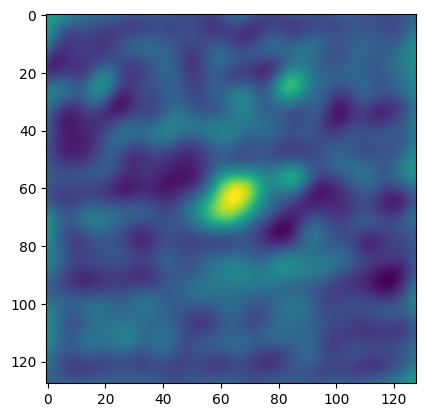

In [17]:
plt.imshow(x[0].detach().cpu().numpy()[0])

In [18]:
with open(f"{exp_name}_train_loss.pkl", "wb") as file:
    pickle.dump(train_loss_list, file)
    
with open(f"{exp_name}_test_loss.pkl", "wb") as file:
    pickle.dump(test_loss_list, file)

In [19]:
train_loss_list = pickle.load(open(f'{exp_name}_train_loss.pkl', 'rb'))
test_loss_list = pickle.load(open(f'{exp_name}_test_loss.pkl', 'rb'))

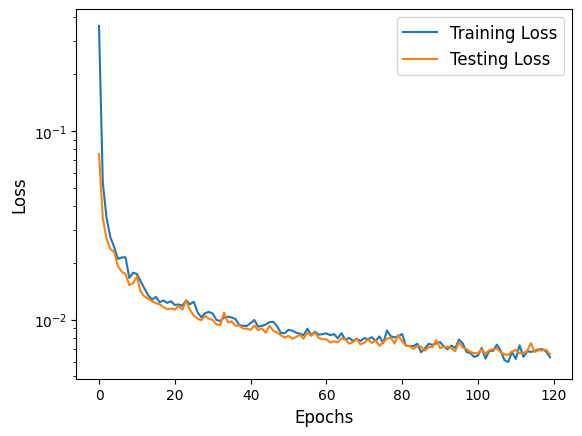

In [20]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.yscale('log')
plt.legend(fontsize='large')  # 设置图例标签的字体大小
plt.xlabel('Epochs', fontsize='large')  # 设置x轴标签的字体大小
plt.ylabel('Loss', fontsize='large')  # 设置y轴标签的字体大小
plt.savefig('loss.png', dpi=400)
plt.show()

In [21]:
f_name = f'./{exp_name}.pt'
torch.save(unet.state_dict(), f_name)

In [22]:
print(f_name)

./experiment_lr=0.0005-epochs=120-shape=1.0-scale=0.1-ssim-0.01-l1-0.5.pt
